In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import zipfile
import os
import csv
import gc
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import roc_auc_score,roc_curve, RocCurveDisplay, auc, make_scorer, ConfusionMatrixDisplay, confusion_matrix, classification_report
import zipfile
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.ensemble import GradientBoostingClassifier,  HistGradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance
import torch

import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import class_weight
from vecstack import stacking
import torch.nn as nn
import torch.nn.functional as F
import joblib


In [ ]:
x_train = pd.read_parquet('/kaggle/input/feature-engineering/x_train.parquet')
x_test = pd.read_parquet('/kaggle/input/feature-engineering/x_test.parquet')
y_train = pd.read_csv('/kaggle/input/feature-engineering/y_train.csv')
y_test = pd.read_csv('/kaggle/input/feature-engineering/y_test.csv')

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2400000, 160), (600000, 160), (2400000, 1), (600000, 1))

In [ ]:
scaler =  StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

In [ ]:
y_train = y_train.values.ravel()

In [ ]:
roc_auc=make_scorer(roc_auc_score)

In [ ]:
#некоторые эксперименты с подбором параметров градиентного бустинга уже были проведены для этого датасета, уточним их
#params = {'max_depth':[11, 13, 15], 'max_leaf_nodes':[70, 72, 74], 'min_samples_leaf':[ 28, 30, 32]}
#grid = GridSearchCV(estimator=HistGradientBoostingClassifier(class_weight='balanced', max_iter=150, scoring='roc_auc', tol=0.00001, l2_regularization=0.01, learning_rate=0.1), param_grid=params, cv=3, scoring=roc_auc

In [ ]:
#grid.best_params_

In [ ]:
def eval_classifier(model, x, y):
    probs = model.predict_proba(x)
    probs = probs[:, 1]
    clf_auc = roc_auc_score(y, probs)
    print('ROC AUC=%.3f' % (clf_auc))

    print(classification_report(y, model.predict(x) ))

    cm = confusion_matrix(y, model.predict(x), labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [ ]:
grad_fast = HistGradientBoostingClassifier(class_weight='balanced', max_depth=15, max_leaf_nodes=72, min_samples_leaf=28, max_iter=150, scoring='roc_auc', tol=0.00001, l2_regularization=0.01, learning_rate=0.1, verbose=5)
grad_fast.fit(x_train, y_train)



ROC AUC=0.756
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    578712
           1       0.07      0.70      0.13     21288

    accuracy                           0.68    600000
   macro avg       0.53      0.69      0.47    600000
weighted avg       0.95      0.68      0.78    600000



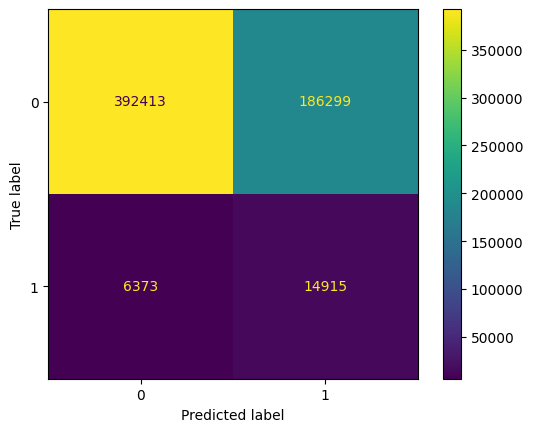

In [ ]:
eval_classifier(grad_fast, x_test, y_test)

In [ ]:
logreg = LogisticRegressionCV(class_weight='balanced', refit=True, cv=3, scoring='roc_auc', max_iter=1000)
logreg.fit(x_train, y_train)

LogisticRegressionCV(class_weight='balanced', cv=3, max_iter=1000,
                     scoring='roc_auc')

ROC AUC=0.744
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    578712
           1       0.07      0.68      0.13     21288

    accuracy                           0.69    600000
   macro avg       0.53      0.68      0.47    600000
weighted avg       0.95      0.69      0.78    600000



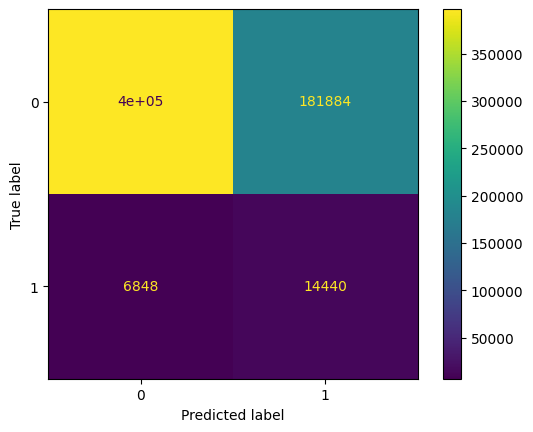

In [ ]:
eval_classifier(logreg, x_test, y_test)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

train_data = MyDataset(x_train, y_train)

batch_size = 64

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)



In [ ]:

n_features = x_train.shape[1]
hidden_layer_size = round((n_features/3)*2)

class BaseClassifier(nn.Module):
    def __init__(self, input_dim=n_features, hidden_dim=hidden_layer_size, output_dim=1):
        super().__init__()

        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.f1 = nn.Sigmoid()

        self.hidden2 = nn.Linear(hidden_dim, 10)
        self.f2 = nn.Sigmoid()

        self.output = nn.Linear(10, output_dim)
        self.f3 = nn.Sigmoid()

    def forward(self, x):
        x = self.f1(self.hidden1(x))
        x = self.f2(self.hidden2(x))
        x  = self.f3(self.output(x))

        return x

basenet = BaseClassifier()


optimizer = torch.optim.SGD(basenet.parameters(), lr=0.01)

num_epochs = 10
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                      classes=np.unique(y_train),
                                                      y=y_train)

for epoch in range(num_epochs):
        for X, y in train_dataloader:
            pred = basenet(X)

            weights = torch.zeros_like(y.unsqueeze(-1))
            weights[y==0] = class_weights[0]
            weights[y==1] = class_weights[1]
            loss = F.binary_cross_entropy(pred, y.unsqueeze(-1), weight=weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [ ]:
x_test_tensor =torch.from_numpy(x_test.astype(np.float32))

y_pred_proba = basenet(x_test_tensor).cpu().detach().numpy().ravel()

auc = round(roc_auc_score(y_test, y_pred_proba), 4)


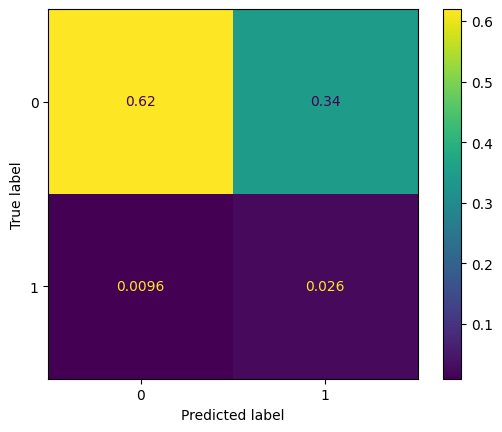

In [ ]:
y_pred = np.round(basenet(x_test_tensor).cpu().detach().numpy().ravel())
cm = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.64      0.78    578712
           1       0.07      0.73      0.13     21288

    accuracy                           0.65    600000
   macro avg       0.53      0.69      0.45    600000
weighted avg       0.95      0.65      0.75    600000



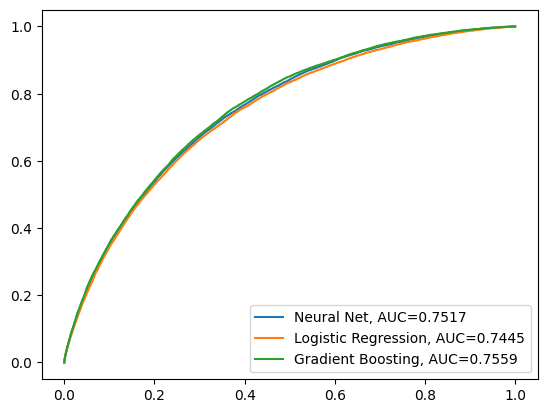

In [ ]:
plt.figure(0).clf()

y_pred = basenet(x_test_tensor).cpu().detach().numpy().ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot (fpr,tpr,label="Neural Net, AUC="+str(auc))

y_pred = logreg.predict_proba (x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot (fpr,tpr,label="Logistic Regression, AUC="+str(auc))


y_pred = grad_fast.predict_proba (x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot (fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

#add legend
plt.legend()




In [ ]:
#Попробуем добавить результаты стекинга в качестве дополнительных признаков

scale_pos_weight = round(len(y_train[y_train==0])/len(y_train[y_train==1]))

model_1 = logreg
model_2 = grad_fast
model_3 = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, learning_rate=0.1, max_depth=11)


l1models = [model_1, model_2, model_3]


s_train, s_test = stacking(l1models, x_train, y_train, x_test,
                            regression=False, needs_proba=True, mode='oof_pred_bag', metric=roc_auc_score, n_folds=3, random_state=0,
                            stratified=True, shuffle=True)





In [ ]:
#вынесем IsolationForest в отдельный уровень, т.к. у него нет predict_proba
l2models = [IsolationForest(contamination=0.0354)]
s_train2, s_test2 = stacking(l2models,  x_train, y_train, x_test,
                            regression=False, needs_proba=False, mode='oof_pred_bag',  n_folds=3, random_state=0,
                            stratified=True,shuffle=True )


In [ ]:
s_train.shape

(2400000, 6)

In [ ]:
s_train = pd.DataFrame(s_train, columns=['mod1_0', 'mod1_1', 'mod2_0', 'mod2_1', 'mod3_0', 'mos=3_1'])
s_train = s_train.drop(['mod1_1',  'mod2_1',  'mos=3_1'],axis=1) #признаки _0 и _1 коррелируют, достаточно одного
s_test = pd.DataFrame(s_test, columns=['mod1_0', 'mod1_1', 'mod2_0', 'mod2_1', 'mod3_0', 'mos=3_1'])
s_test = s_test.drop(['mod1_1',  'mod2_1',  'mos=3_1'],axis=1)

In [ ]:
s_train.to_parquet('s_train.parquet')
s_test.to_parquet('s_test.parquet')



In [ ]:
pd.DataFrame(s_train2).to_parquet('s_train2.parquet')
pd.DataFrame(s_test2).to_parquet('s_test2.parquet')

In [ ]:
#s_train = pd.read_parquet('/kaggle/working/s_train.parquet')
#s_test = pd.read_parquet('/kaggle/working/s_test.parquet')
#s_train2 = pd.read_parquet('/kaggle/working/s_train2.parquet')
#s_test2 = pd.read_parquet('/kaggle/working/s_test2.parquet')

In [ ]:
x_train_new = pd.DataFrame(x_train).join(s_train)
x_train_new['if'] = s_train2
x_train_new.columns = x_train_new.columns.astype(str)

x_test_new = pd.DataFrame(x_test).join(s_test)
x_test_new['if'] = s_test2
x_test_new.columns = x_test_new.columns.astype(str)

In [ ]:
x_train_new.shape

(2400000, 164)

In [ ]:
#в качестве финального классификатора попробуем NN и градиентный бустинг
grad_fin = HistGradientBoostingClassifier(class_weight='balanced', max_depth=15,  max_leaf_nodes=72, min_samples_leaf=30, max_iter=150, scoring='roc_auc', tol=0.00001, l2_regularization=0.01, learning_rate=0.1)
grad_fin.fit(x_train_new, y_train)

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=0.01,
                               max_depth=15, max_iter=150, max_leaf_nodes=72,
                               min_samples_leaf=30, scoring='roc_auc',
                               tol=1e-05)

ROC AUC=0.759
              precision    recall  f1-score   support

           0       0.98      0.67      0.80    578712
           1       0.07      0.72      0.13     21288

    accuracy                           0.67    600000
   macro avg       0.53      0.69      0.47    600000
weighted avg       0.95      0.67      0.77    600000



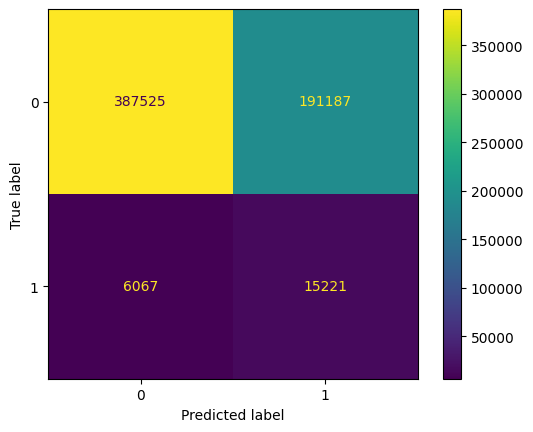

In [ ]:
eval_classifier(grad_fin, x_test_new, y_test )

In [ ]:
n_features = x_train_new.shape[1]

x_train_new = x_train_new.to_numpy()
x_test_new = x_test_new.to_numpy()

In [ ]:
train_data = MyDataset(x_train_new, y_train)

batch_size = 64
num_epochs=10

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)


hidden_layer_size = round((n_features/3)*2)
class BaseClassifier(nn.Module):
    def __init__(self, input_dim=n_features, hidden_dim=hidden_layer_size, output_dim=1):
        super().__init__()

        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.f1 = nn.Sigmoid()

        self.hidden2 = nn.Linear(hidden_dim, 10)
        self.f2 = nn.Sigmoid()

        self.output = nn.Linear(10, output_dim)
        self.f3 = nn.Sigmoid()

    def forward(self, x):
        x = self.f1(self.hidden1(x))
        x = self.f2(self.hidden2(x))
        x  = self.f3(self.output(x))

        return x

fin_net = BaseClassifier()

for epoch in range(num_epochs):
        for X, y in train_dataloader:
            pred = fin_net(X)

            weights = torch.zeros_like(y.unsqueeze(-1))
            weights[y==0] = class_weights[0]
            weights[y==1] = class_weights[1]
            loss = F.binary_cross_entropy(pred, y.unsqueeze(-1), weight=weights)
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()



In [ ]:
x_test_new_tensor =torch.from_numpy(x_test_new.astype(np.float32))



In [ ]:
y_pred_proba = fin_net(x_test_new_tensor).cpu().detach().numpy().ravel()
auc = round(roc_auc_score(y_test, y_pred), 4)
auc

0.7559

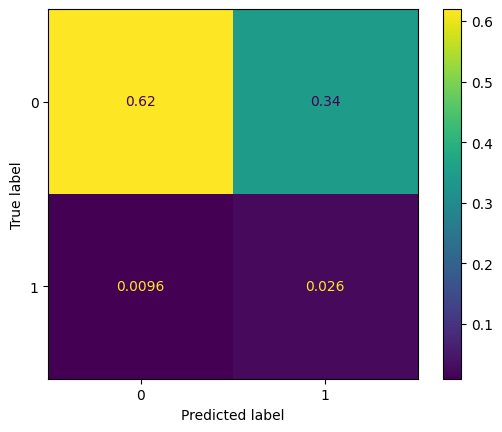

In [ ]:
y_pred = np.round(basenet(x_test_tensor).cpu().detach().numpy().ravel())
cm = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()


In [ ]:
#собранная сеть дает неплохой результат и, вероятно, его можно было бы улучшить, но HistGradientBoostingClassifier однозначно лидирует
#и по метрике, и по простоте использования (в частности, еще предстоит выстраивать пайплайн), и по скорости обучения.
#задачу добиться максимально возможной на этих данных метрики подбором параметров и гиперпараметров не ставлю
